In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import xgboost as xgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2914,0484-FFVBJ,Male,0,No,No,32,Yes,No,DSL,No,...,No,No,Yes,Yes,One year,Yes,Bank transfer (automatic),64.85,2010.95,No
2212,8076-FEZKJ,Male,0,No,No,10,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.50,225.85,No
5446,6141-OOXUQ,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.65,19.65,Yes
3372,2883-ILGWO,Male,1,No,No,57,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),104.90,5913.95,No
1393,2592-YKDIF,Female,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.35,20.35,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

## Observation
- Imbalanced target variable 

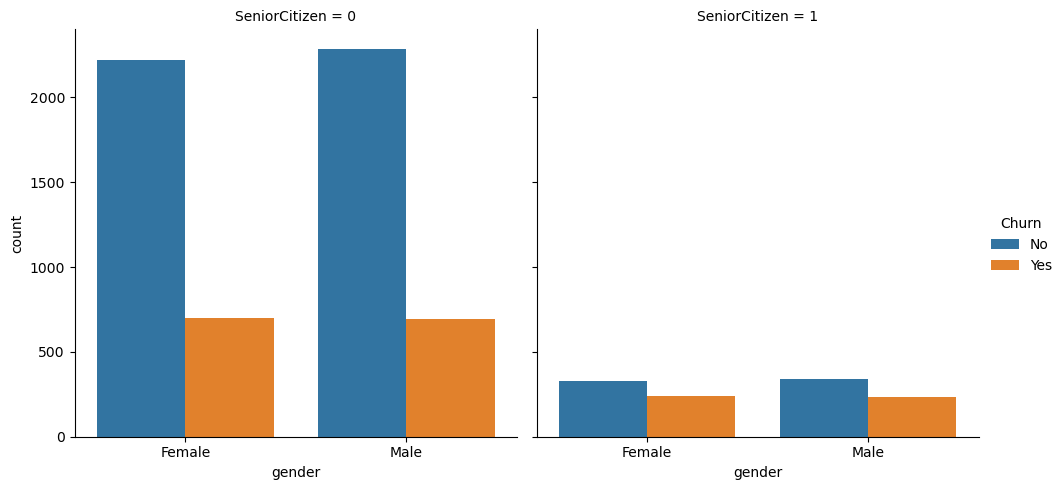

In [6]:
sns.catplot(x='gender', hue='Churn', col='SeniorCitizen', data=df, kind='count')
plt.show()

# Observations

- number of senior citizen is less than non senior citizen
- gender is almost equally distributed in both non senior citizen and senior citizen
- Equal distribution of churn in male and female

In [7]:
df['TotalCharges'].replace(" ", 0, inplace = True)

In [8]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [10]:
df['SeniorCitizen'] = df['SeniorCitizen'].apply(lambda x:'No' if x == 0 else 'Yes')

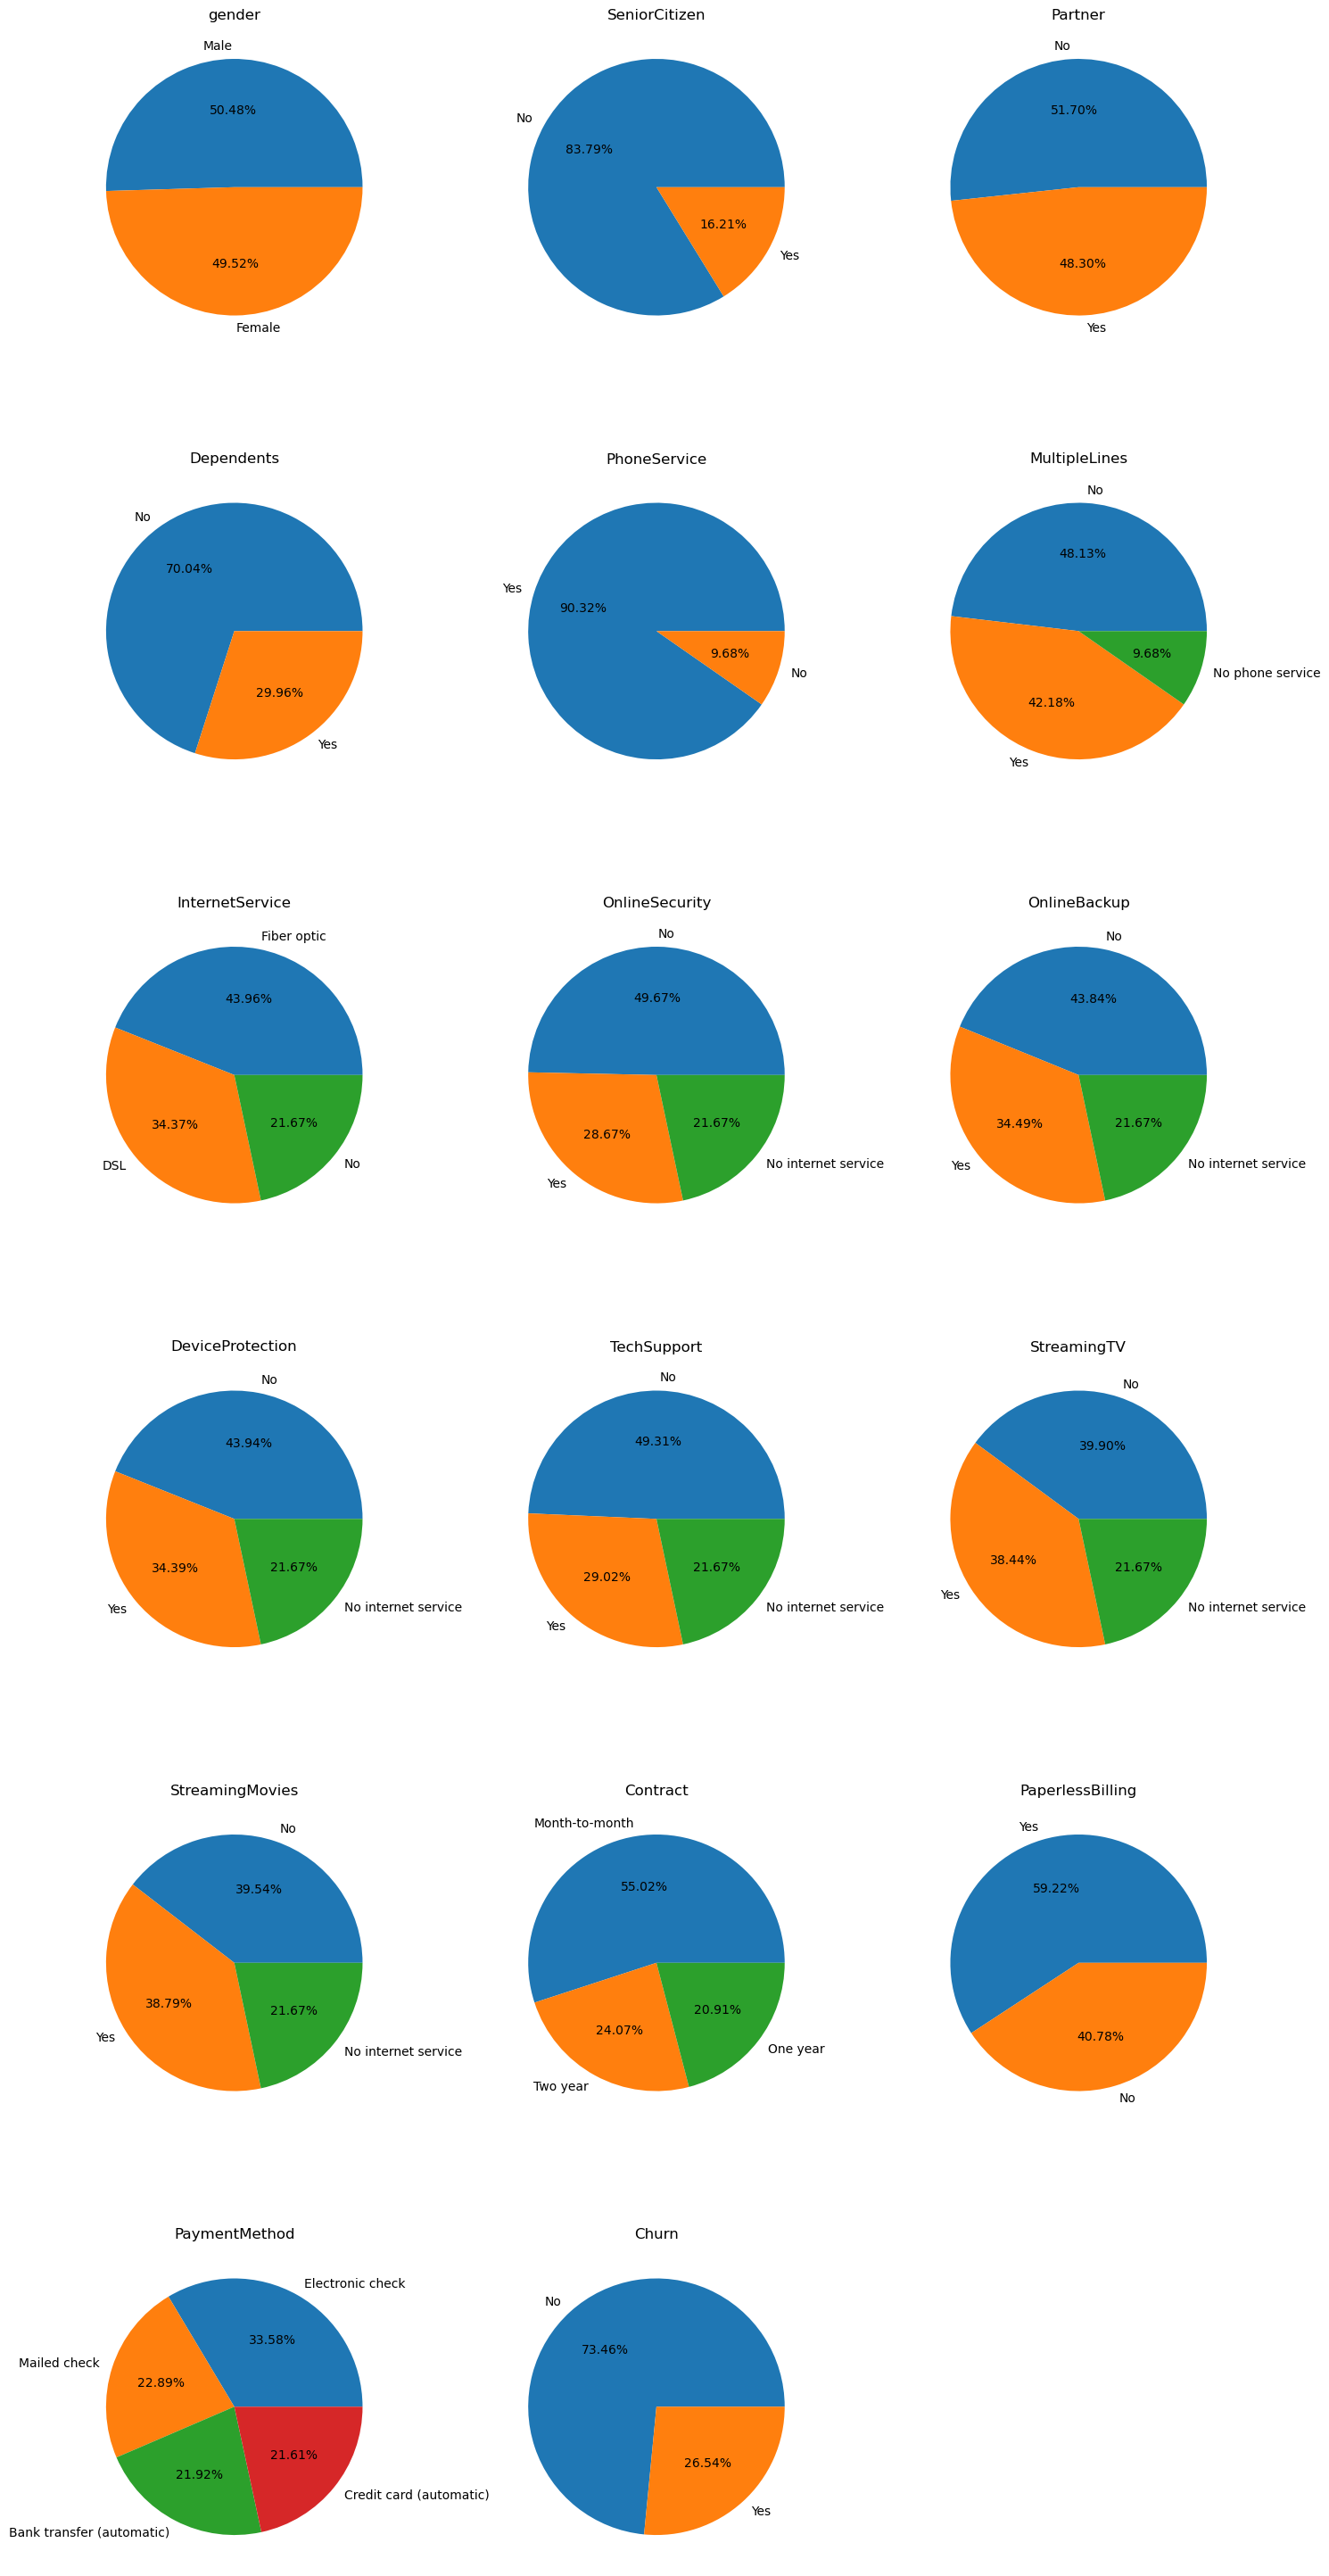

In [11]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O' and col != 'customerID']
n = len(cat_cols)

cols = 3  # Charts per row
rows = math.ceil(n / cols)  # Auto calc rows needed

plt.figure(figsize=(5 * cols, 5 * rows))  # Adjust figure size

for i, col in enumerate(cat_cols):
    plt.subplot(rows, cols, i+1)

    data = df[col].value_counts().values
    labels = df[col].value_counts().index

    plt.pie(data, labels=labels, autopct='%1.2f%%')
    plt.title(col)

plt.tight_layout()
plt.show()

# Feature Engineering
- Internet service (binary) as yes or no (have internet service or not)

In [12]:
df.rename(columns={'InternetService' : 'InternetServiceTypes'}, inplace=True)

In [13]:
df['InternetService'] = df['InternetServiceTypes'].apply(lambda x:'Yes' if x in ['DSL', 'Fiber optic'] else 'No')

In [14]:
df['InternetService'].value_counts()

InternetService
Yes    5517
No     1526
Name: count, dtype: int64

In [15]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetServiceTypes,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService
566,6967-QIQRV,Male,No,Yes,Yes,15,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,One year,No,Electronic check,101.90,1667.25,No,Yes
4962,7088-FBAWU,Female,No,Yes,Yes,17,Yes,No,DSL,Yes,...,No,Yes,Yes,Month-to-month,No,Mailed check,74.55,1215.80,No,Yes
1212,4291-SHSBH,Male,No,No,No,7,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,69.55,521.35,No,Yes
5737,7989-VCQOH,Male,No,Yes,Yes,18,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Month-to-month,No,Electronic check,83.25,1611.15,No,Yes
4671,3393-FMZPV,Female,No,No,No,25,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.25,2387.75,Yes,Yes


# Exploratory Data Analysis

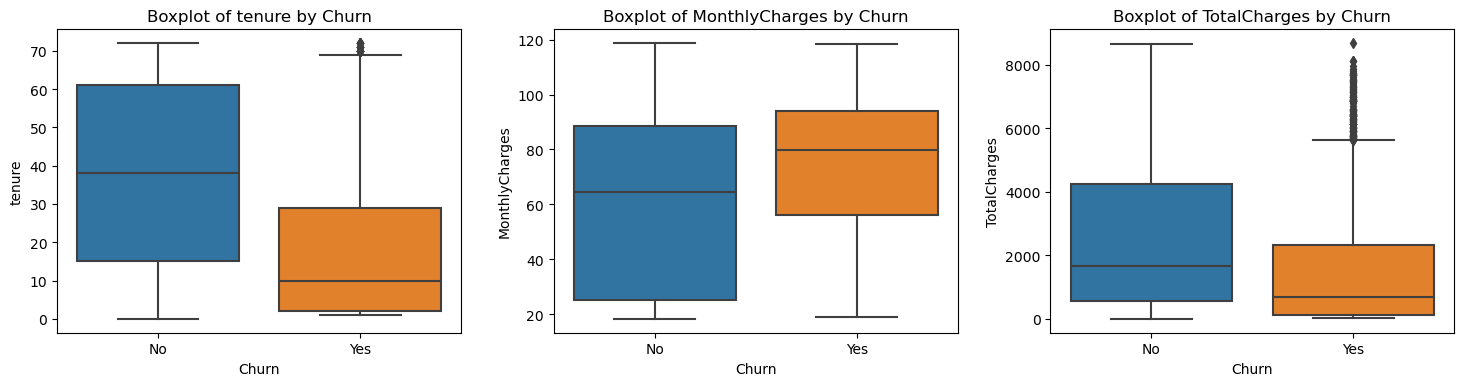

In [16]:
plt.figure(figsize=(15, 30))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

for i, col in enumerate(numeric_cols):
    plt.subplot(8, 3, i + 1)
    sns.boxplot(data=df, x='Churn', y=col) 
    plt.title(f'Boxplot of {col} by Churn')

plt.tight_layout(pad=2)
plt.show()

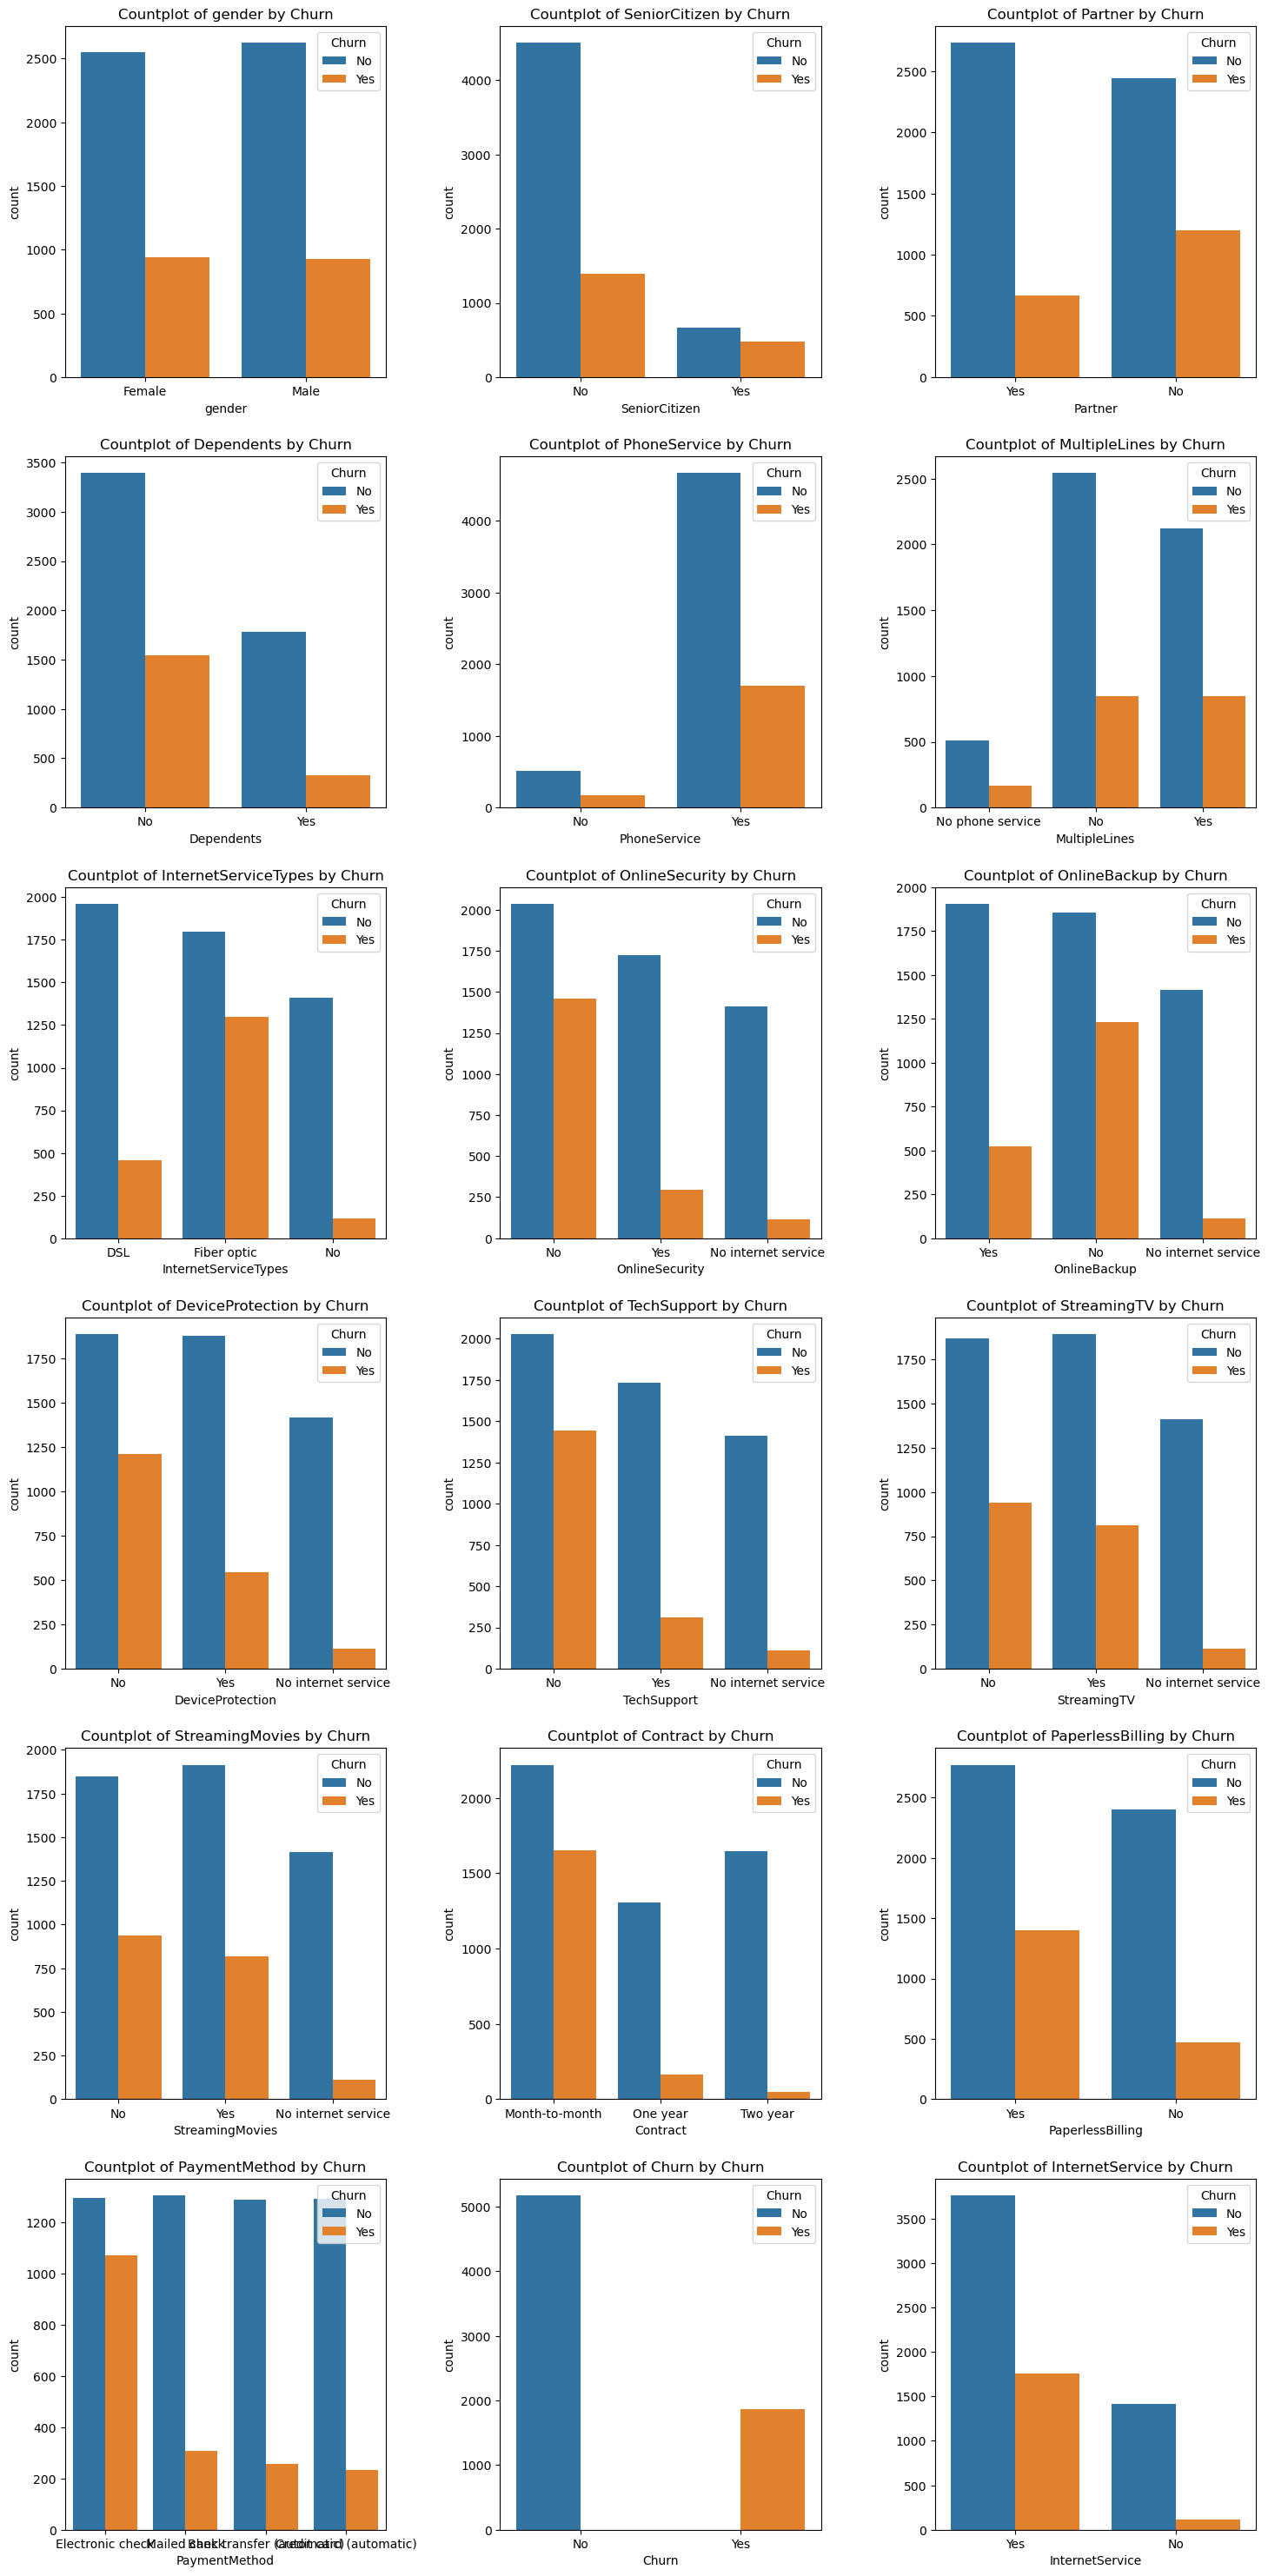

In [17]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O' and col != 'customerID']

plt.figure(figsize=(5 * cols, 5 * rows))

for i, col in enumerate(cat_cols):
    plt.subplot(rows, cols, i+1)
    
    sns.countplot(data=df, x=col, hue='Churn') 
    plt.title(f'Countplot of {col} by Churn')

plt.tight_layout(pad=2)
plt.show()

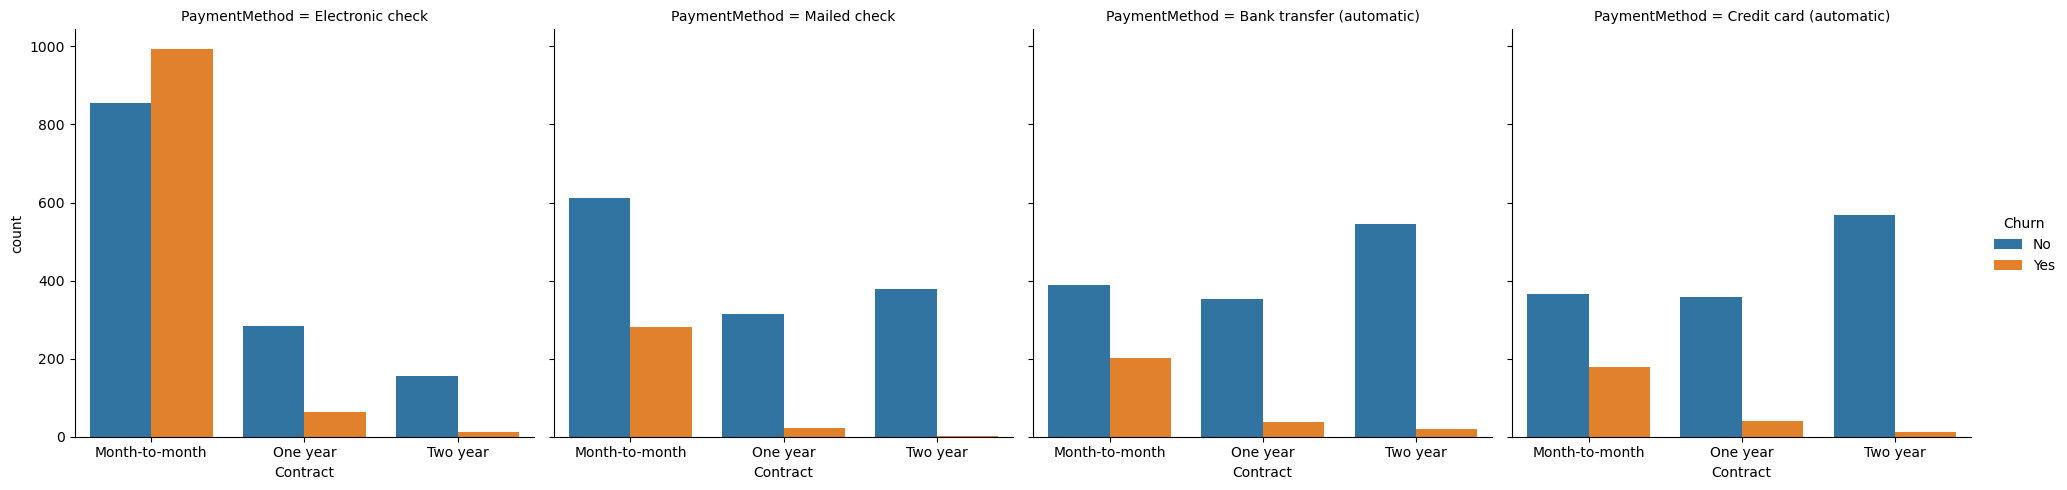

In [18]:
sns.catplot(x='Contract', hue='Churn', col='PaymentMethod', kind='count', data=df)
plt.show()

## Observations
- Customers with month-to-month contracts who pay via electronic check have a significantly higher churn rate compared to other groups.

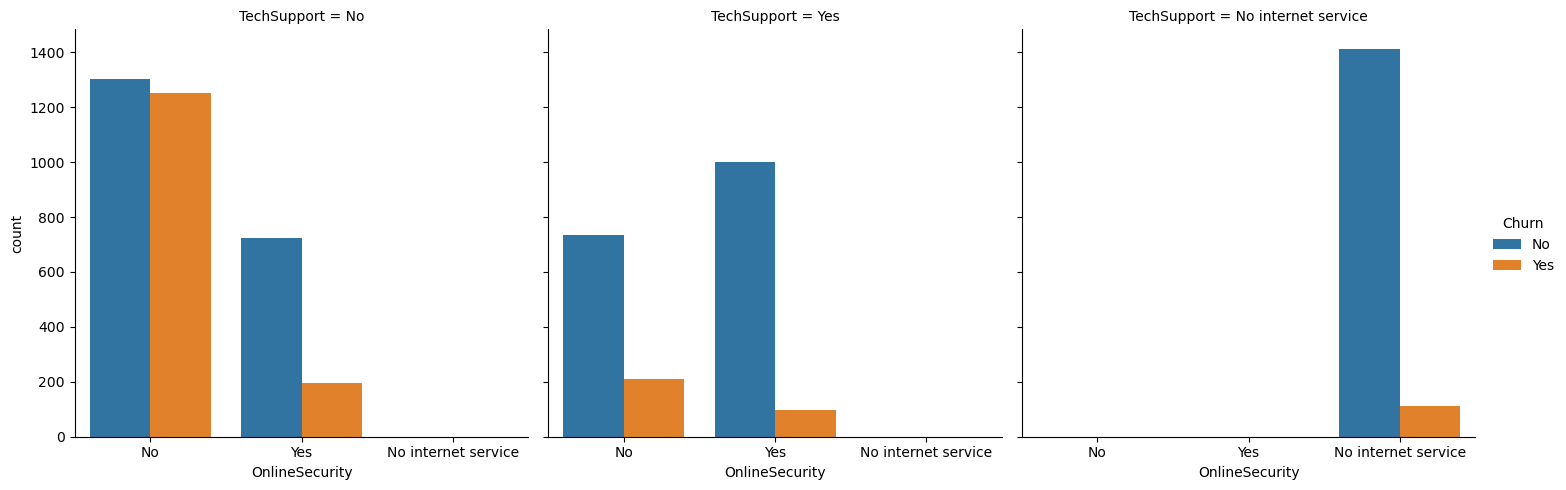

In [19]:
sns.catplot(x='OnlineSecurity', hue='Churn', col='TechSupport', kind='count', data=df)
plt.show()

## Observations
- The customer with no online security and with no techsupport have higher churn rate than others

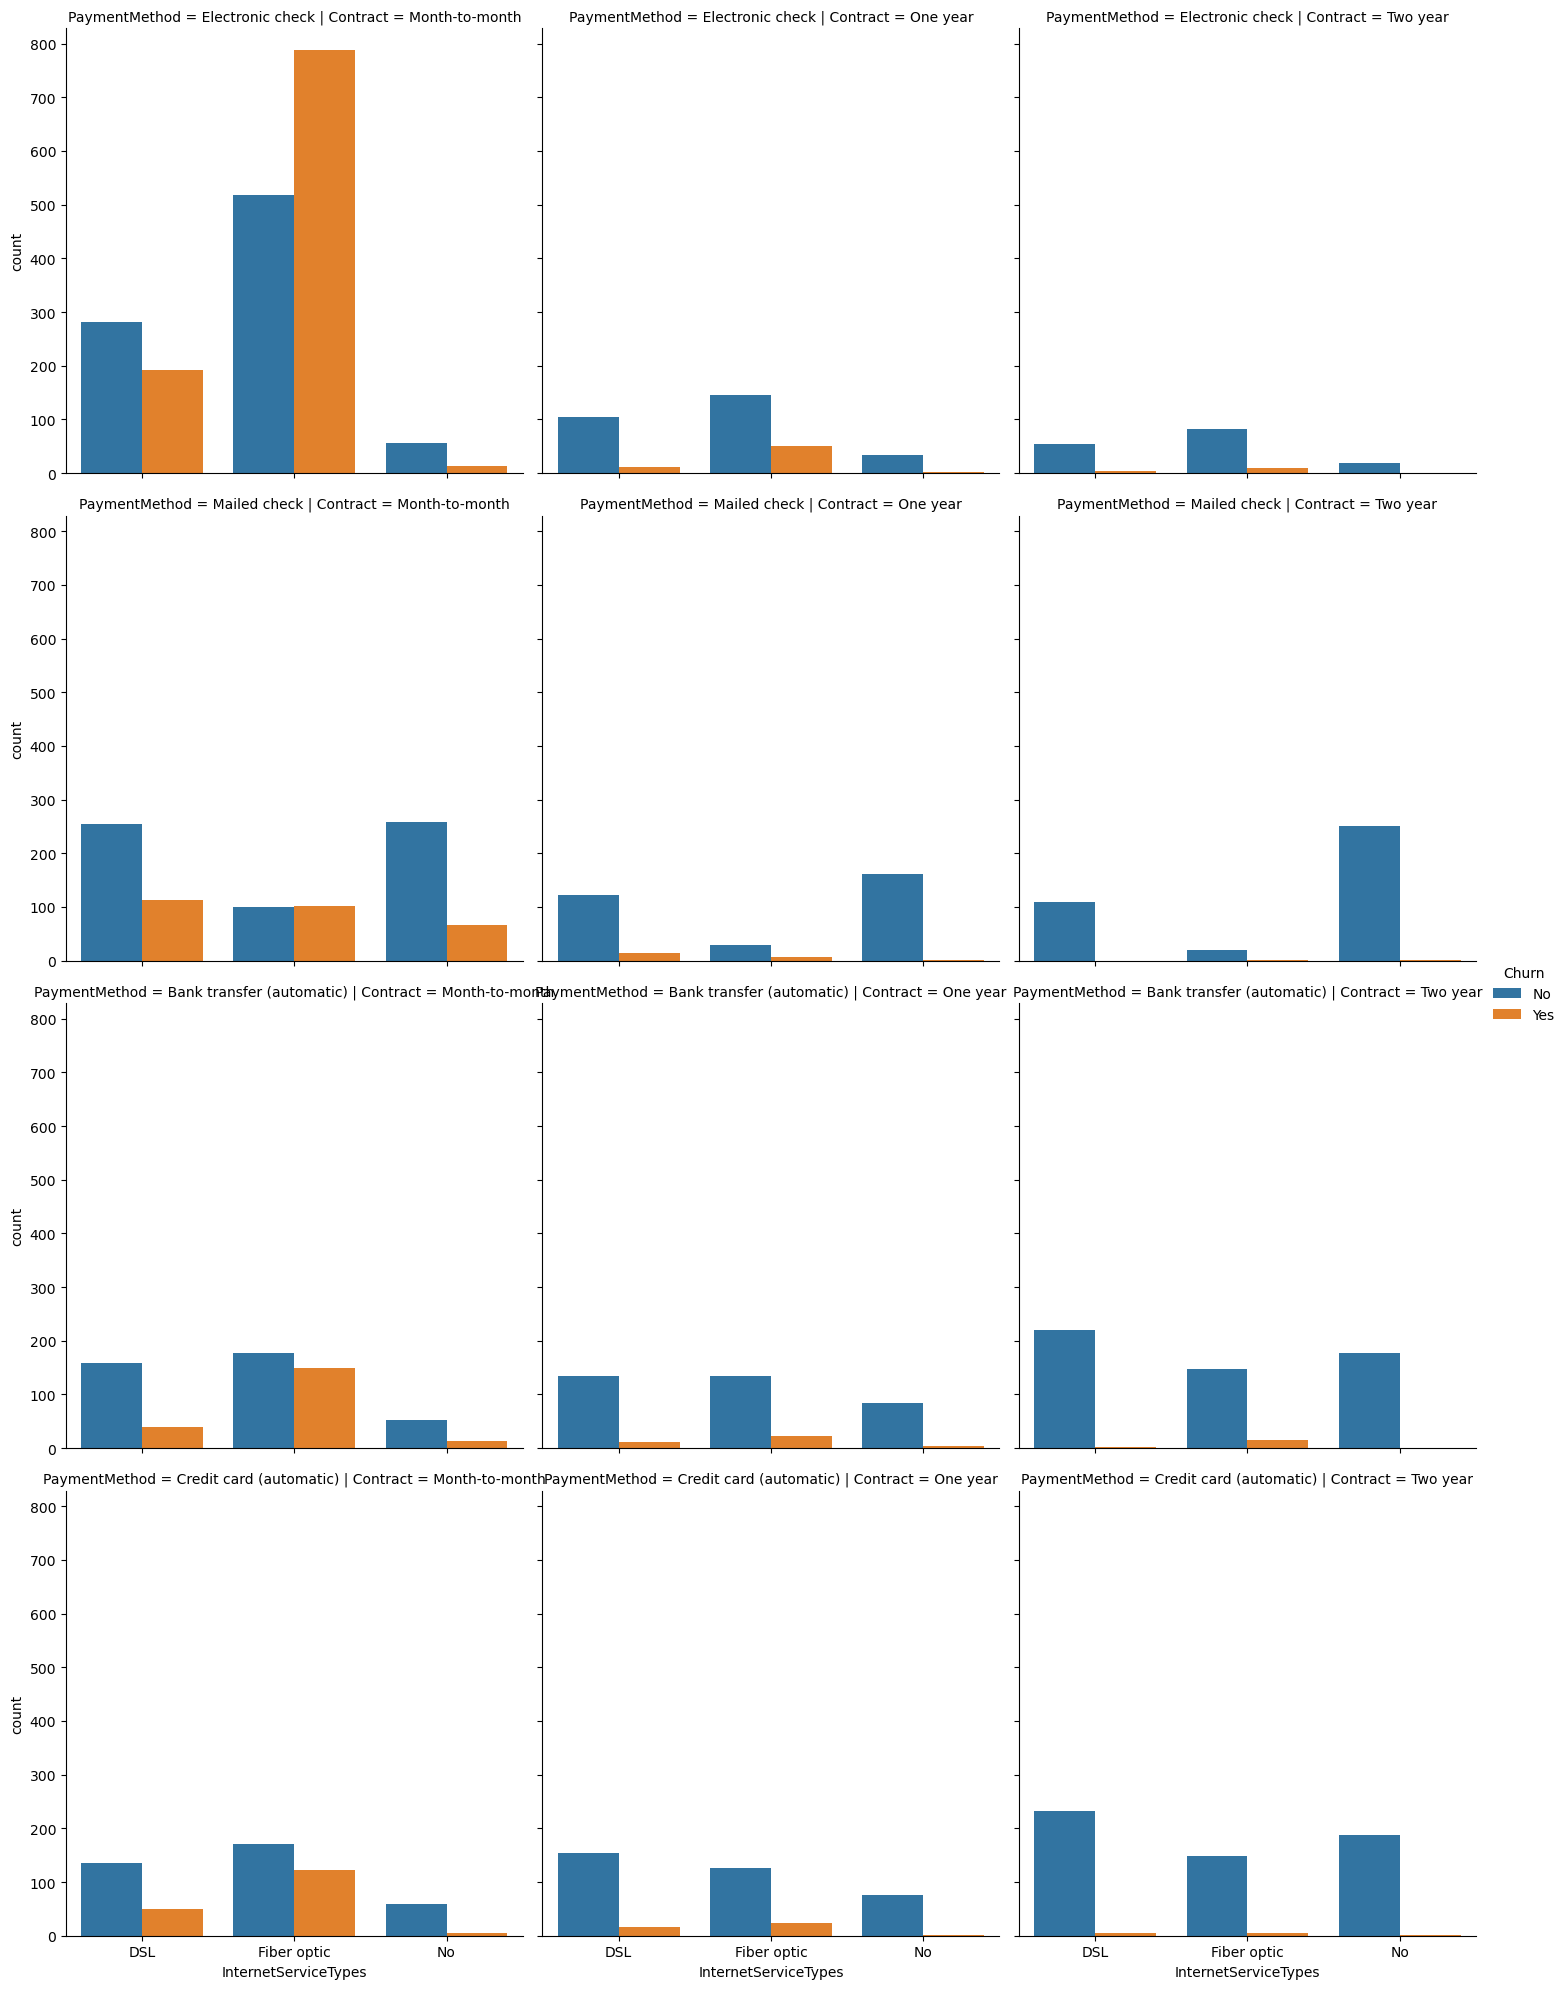

In [20]:
sns.catplot(x='InternetServiceTypes', hue='Churn', col='Contract', row='PaymentMethod', kind='count', data=df)
plt.show()

## Observation
- The customer with fiber optic connection who have month to month contract and pays using electronic check or mailed check have higher churn rate than others

In [21]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetServiceTypes,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetService
5932,4192-GORJT,Male,No,Yes,No,5,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.45,498.10,Yes,Yes
1862,0523-VNGTF,Female,Yes,No,No,52,No,No phone service,DSL,No,...,Yes,Yes,No,Month-to-month,Yes,Electronic check,50.50,2566.30,No,Yes
1128,0098-BOWSO,Male,No,No,No,27,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,19.40,529.80,No,No
6885,7603-USHJS,Male,No,No,Yes,12,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Credit card (automatic),73.75,871.40,Yes,Yes
6690,5161-XEUVX,Male,No,Yes,No,37,Yes,Yes,Fiber optic,No,...,Yes,Yes,No,Two year,No,Mailed check,94.30,3460.95,No,Yes


In [22]:
df.drop(columns=['customerID'], inplace = True)

In [23]:
df_dummy = pd.get_dummies(df, dtype='int', drop_first=True)

In [24]:
df_dummy.sample(5)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,InternetService_Yes
108,43,94.35,3921.30,1,0,0,0,1,0,1,...,0,1,1,0,0,0,0,1,0,1
6183,44,54.30,2317.10,1,0,1,1,0,1,0,...,0,1,1,0,1,0,1,0,0,1
3683,71,54.50,3778.20,1,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
200,27,101.90,2681.15,0,0,1,0,1,0,0,...,0,1,1,0,1,1,0,0,0,1
4039,7,94.10,701.30,1,0,0,0,1,0,1,...,0,1,0,0,1,0,1,0,0,1


Text(0.5, 1.0, 'Monthly charges by churn')

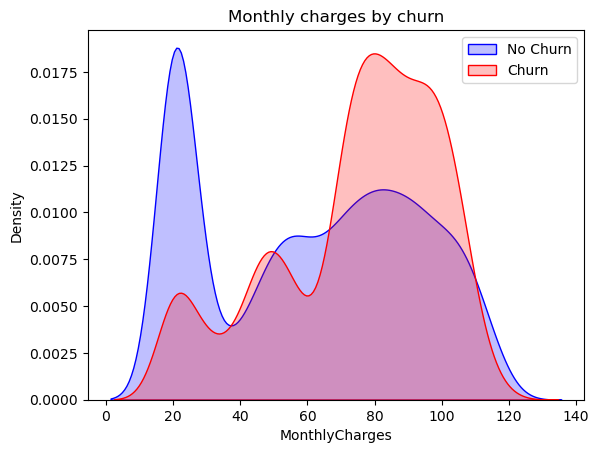

In [25]:
Mth = sns.kdeplot(df_dummy.MonthlyCharges[df_dummy["Churn_Yes"] == 0], color="Blue", shade=True)
Mth = sns.kdeplot(df_dummy.MonthlyCharges[df_dummy["Churn_Yes"] == 1], color="Red", shade=True)

Mth.legend(["No Churn", "Churn"])
Mth.set_title('Monthly charges by churn')

[]

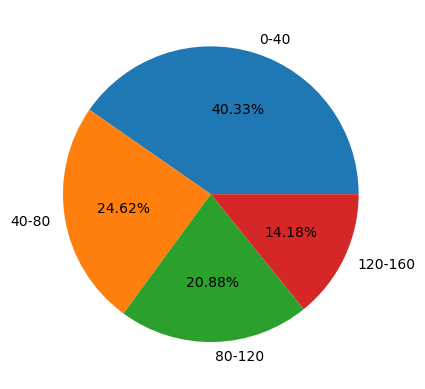

In [26]:
bins = [0, 40, 80, 120, 160]
labels = ['0-40', '40-80', '80-120', '120-160']

TC = pd.cut(df['TotalCharges'], bins=bins, labels=labels, include_lowest=True)

plt.pie(TC.value_counts(), labels = labels, autopct='%1.2f%%')
plt.plot()

## Observations
- As monthly charges increase, the customer churn rate also rises, indicating a potential correlation between higher charges and customer dissatisfaction or service cancellation.
- The majority of customers have monthly charges in the range of 0–40, suggesting that most users are on lower-tier plans or use minimal services.

Text(0.5, 1.0, 'Monthly charges by churn')

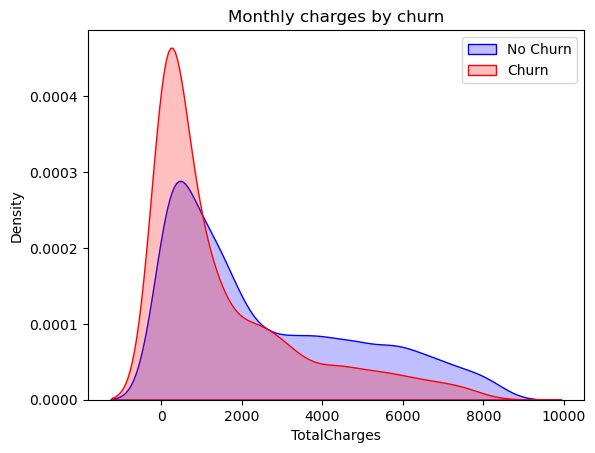

In [27]:
Tot = sns.kdeplot(df_dummy.TotalCharges[df_dummy["Churn_Yes"] == 0], color="Blue", shade=True)
Tot = sns.kdeplot(df_dummy.TotalCharges[df_dummy["Churn_Yes"] == 1], color="Red", shade=True)

Tot.legend(["No Churn", "Churn"])
Tot.set_title('Monthly charges by churn')

[]

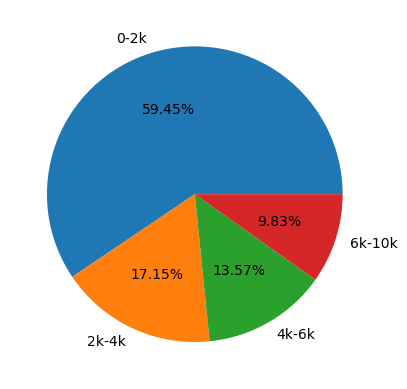

In [28]:
bins = [0, 2000, 4000, 6000, 10000]
labels = ['0-2k', '2k-4k', '4k-6k', '6k-10k']

TC = pd.cut(df['TotalCharges'], bins=bins, labels=labels, include_lowest=True)

plt.pie(TC.value_counts(), labels = labels, autopct='%1.2f%%')
plt.plot()

## Observations

- The majority of customers fall within the 0–2k TotalCharges bracket.
- This group also exhibits a higher churn rate, suggesting that lower-spending customers are more likely to leave—possibly due to cost sensitivity or lower service commitment.

In [29]:
X = df_dummy.drop(columns=['Churn_Yes'])
y = df_dummy['Churn_Yes']

### Using SMOTE-ENN to balance target variable

In [30]:
from imblearn.combine import SMOTEENN

In [31]:
sm = SMOTEENN()

X_resampled, y_resampled = sm.fit_resample(X,y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [33]:
# Models and their hyperparameter grids
models = {
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=100),
        "param_grid": {
            "max_depth": [6, 10, 15],
            "min_samples_leaf": [8, 12, 20]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=100),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 10, 15],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=100),
        "param_grid": {
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "n_estimators": [100, 200],
            "subsample": [0.8, 0.9]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=100),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(solver='liblinear', random_state=100),
        "param_grid": {
            "C": [0.1, 1, 10],
            "penalty": ['l2']
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7],
            "metric": ['euclidean', 'manhattan']
        }
    }
}

# Dictionary to store the results
results = {}

In [34]:
# Looping through each model, performing GridSearchCV and evaluate
for model_name, model_details in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    
    # GridSearchCV
    grid_search = GridSearchCV(model_details["model"], model_details["param_grid"], cv=5, scoring='roc_auc', verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    
    # Results
    results[model_name] = {
        "Best Parameters": grid_search.best_params_,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": matrix
    }

    # Results for this model
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{matrix}")
    print("-" * 50)

print("\nSummary of Model Performances:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Training and evaluating Decision Tree...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 20}
Accuracy: 0.9150
Precision: 0.9025
Recall: 0.9480
F1-Score: 0.9247
Confusion Matrix:
[[453  65]
 [ 33 602]]
--------------------------------------------------

Training and evaluating Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for Random Forest: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9471
Precision: 0.9348
Recall: 0.9717
F1-Score: 0.9529
Confusion Matrix:
[[475  43]
 [ 18 617]]
--------------------------------------------------

Training and evaluating XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
Accuracy: 0.9436
Precision: 0.9412
Recall: 0.9575
F1-Score: 0.9493
Confus

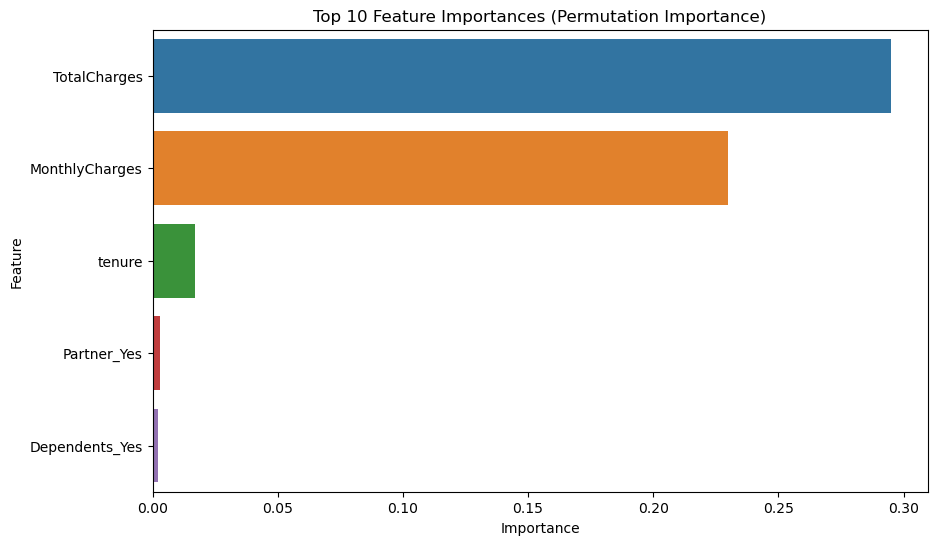

In [37]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(5))
plt.title("Top 10 Feature Importances (Permutation Importance)")
plt.show()